In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from scipy.integrate import simps
from copy import deepcopy
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

# Read data

In [6]:
# read bacterial relative abundance
df_16S_relab = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)

# read qPCR
df_qpcr = pd.read_csv('../../../our_data/qPCR.csv', index_col=0).rename({'Value':'qPCR'},axis=1)

# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_16S_relab = df_16S_relab.loc[df_meta.index]
df_qpcr = df_qpcr.loc[df_meta.index]
df_meta = pd.merge(df_meta, df_16S_relab, left_index=True, right_index=True)
df_meta = pd.merge(df_meta, df_qpcr, left_index=True, right_index=True)

# calculate total relative abundance of inulin responders
inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
df_meta['AllResponders'] = df_meta[inulin_responders].sum(axis=1)
df_meta['BaMu'] = df_meta[['Bacteroides-acidifaciens','Muribaculaceae']].sum(axis=1)
#df_meta['BaMu'] = stats.gmean(df_meta[['Bacteroides-acidifaciens','Muribaculaceae']], axis=1)
df_meta['BaMuFa'] = df_meta[['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum']].sum(axis=1)

df_meta.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,A2,ASF356,Acetatifactor,Acetatifactor-muris,Acidovorax,...,bacterium-enrichment-culture-clone-M153,gut-metagenome,human-gut-metagenome,marine-metagenome,metagenome,mouse-gut-metagenome,qPCR,AllResponders,BaMu,BaMuFa
SampleID,,,,,,,,,,,,,,,,,,,,,
sample141,BI1,Beijing,0,Inulin,A,0.000000,0.000795,0.001339,0.0,0.0,...,0.0,0.002735,0.0,0.000000,0.0,0.002832,7.332081e+07,0.658021,0.358857,0.563913
sample142,BI2,Beijing,0,Inulin,B,0.001752,0.000554,0.000734,0.0,0.0,...,0.0,0.001056,0.0,0.000039,0.0,0.002371,4.562151e+07,0.539051,0.301098,0.490234
sample143,BI3,Beijing,0,Inulin,D,0.000000,0.000849,0.000394,0.0,0.0,...,0.0,0.001029,0.0,0.000000,0.0,0.001672,1.625439e+08,0.347159,0.288172,0.332213
sample144,BI4,Beijing,0,Inulin,E,0.000463,0.001064,0.000704,0.0,0.0,...,0.0,0.001235,0.0,0.000051,0.0,0.000000,1.337674e+08,0.221404,0.190998,0.210800
sample145,BI5,Beijing,0,Inulin,C,0.000000,0.000765,0.000744,0.0,0.0,...,0.0,0.002296,0.0,0.000000,0.0,0.000461,1.606161e+08,0.391445,0.300106,0.367085


# Predict absolute abundance from relative abundance

In [98]:
lines = []
covariants = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides', 'BaMu', 'AllResponders']
for responder in covariants:
    pearson_coef, pearson_P = pearsonr(np.asarray(df_meta[responder]), np.asarray(df_meta.qPCR))
    spearman_coef, spearman_P = spearmanr(np.asarray(df_meta[responder]), np.asarray(df_meta.qPCR))
    lines.append([responder, pearson_coef, pearson_P, spearman_coef, spearman_P, pearson_coef**2])
df_responder_qpcr_assoc = pd.DataFrame(lines, columns=['InulinResponder','Pearson','Pearson_P','Spearman','Spearman_P','R2'])
df_responder_qpcr_assoc

,InulinResponder,Pearson,Pearson_P,Spearman,Spearman_P,R2
0,Bacteroides-acidifaciens,0.295553,1.712932e-04,0.535117,5.200866e-13,0.087351
1,Muribaculaceae,0.384592,6.591222e-07,0.440160,8.005687e-09,0.147911
2,Faecalibaculum,-0.224464,4.710330e-03,-0.255639,1.231772e-03,0.050384
3,Parasutterella,-0.413778,7.180561e-08,-0.389428,4.631698e-07,0.171212
4,Bacteroides,-0.498782,2.964559e-11,-0.463920,9.396214e-10,0.248784
5,BaMu,0.511027,8.003964e-12,0.567679,8.989820e-15,0.261148
6,AllResponders,0.126974,1.130389e-01,0.259010,1.054632e-03,0.016122


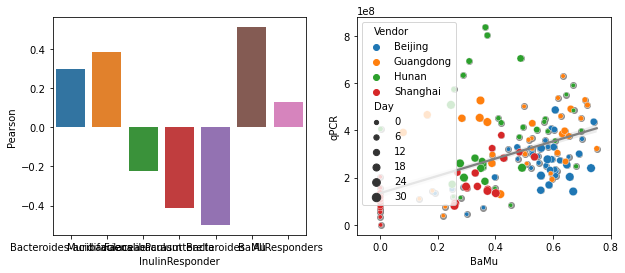

In [99]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# Pearson
_ = sns.barplot(x='InulinResponder', y='Pearson', data=df_responder_qpcr_assoc, ax=ax[0], ci=68)

# Bacteroides-acidifaciens + Muribaculaceae
_ = sns.regplot(x='BaMu', y='qPCR', color='gray', data=df_meta, ax=ax[1], ci=68)
_ = sns.scatterplot(x='BaMu', y='qPCR', hue='Vendor', size='Day', data=df_meta, ax=ax[1])
_ = ax[1].set_xlim([-0.08,0.8])

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('correlation_inulin_responder_vs_qpcr.svg', format='svg')

# Predict response (averaged absolute abundance) from total relative abundance of inulin responders in the baseline

In [13]:
lines = []
covariants = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides',
              'BaMu','AllResponders']

lines = []
lines2 = []
for responder in covariants:
    initial_relab = []
    qpcr_ave = []
    for mice in set(df_meta.MiceID):
        df_tmp = df_meta[df_meta.MiceID==mice].sort_values(by='Day')
        vendor = list(set(df_tmp.Vendor))[0]
        x = list(df_tmp.Day)
        y = list(df_tmp.qPCR)
        initial_relab.append(df_tmp.loc[df_tmp.Day==0,responder].values[0])
        qpcr_ave.append(simps(y,x)/np.max(x))
        
        if responder=='BaMu':
            lines2.append([initial_relab[-1],qpcr_ave[-1],vendor])
    pearson_coef, pearson_P = pearsonr(initial_relab, qpcr_ave)
    spearman_coef, spearman_P = spearmanr(initial_relab, qpcr_ave)
    lines.append([responder, pearson_coef, pearson_P, spearman_coef, spearman_P, pearson_coef**2])
df_responder_qpcr_assoc = pd.DataFrame(lines, columns=['InulinResponder','Pearson','Pearson_P','Spearman','Spearman_P','R2'])
df_responder_qpcr_assoc

,InulinResponder,Pearson,Pearson_P,Spearman,Spearman_P,R2
0,Bacteroides-acidifaciens,0.431158,0.074032,0.678019,0.001985,0.185897
1,Muribaculaceae,0.755860,0.000285,0.622291,0.005819,0.571325
2,Faecalibaculum,-0.132226,0.600960,-0.147575,0.558970,0.017484
3,Parasutterella,-0.002308,0.992748,-0.048504,0.848430,0.000005
4,Bacteroides,-0.766505,0.000207,-0.663571,0.002678,0.587530
5,BaMu,0.767099,0.000203,0.599587,0.008537,0.588440
6,AllResponders,0.009123,0.971339,-0.021672,0.931980,0.000083


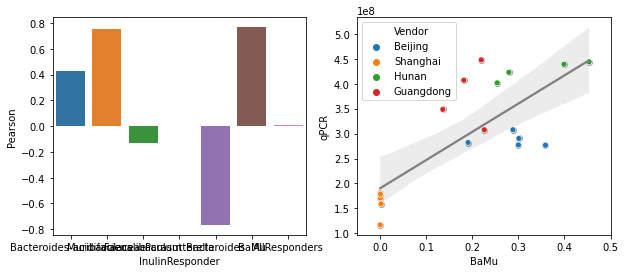

In [14]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# Pearson
_ = sns.barplot(x='InulinResponder', y='Pearson', data=df_responder_qpcr_assoc, ax=ax[0])

# scatterplot
df_tmp = pd.DataFrame(lines2, columns=['BaMu','qPCR','Vendor'])
_ = sns.regplot(x='BaMu', y='qPCR', color='gray', data=df_tmp, ax=ax[1])
_ = sns.scatterplot(x='BaMu', y='qPCR', hue='Vendor', data=df_tmp, ax=ax[1])
_ = ax[1].set_xlim([-0.05,0.5])

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('correlation_baseline_inulin_responder_vs_qpcr_ave.svg', format='svg')

# Plot correlation between top20 species in gLV model

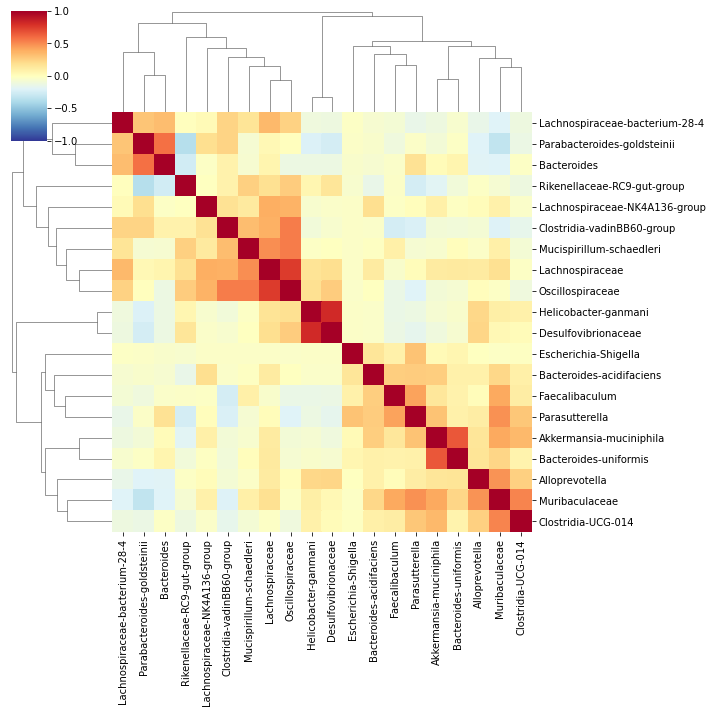

In [68]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet==diet]

# read bacterial absolute abundance
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# select the species included in glv model
df_glv_inulin = pd.read_excel('../../figure3_fiber_responder/inulin/stan_output_summary_absolute_abundance_top20_species.xlsx', index_col=0)
df_glv_inulin = df_glv_inulin[df_glv_inulin.Type=='basal_growth_rate']
taxa_in_glv_model = [t.replace('_slash_','/').replace('_space_',' ').replace('_leftsquarebracket_','[').replace('_rightsquarebracket_',']').replace('_dash_','-').replace('_dot_','.').replace('_leftroundbracket','(').replace('_rightroundbracket_',')') for t in list(set(df_glv_inulin.Taxa))]
df_bac = df_bac[taxa_in_glv_model]

# plot clustermap
_ = sns.clustermap(df_bac.corr(method='pearson'),
                   cmap='RdYlBu_r',
                   vmin=-1,
                   vmax=1
                  )

# Plot point-to-point correlation between species w/ significant indivudalized responses

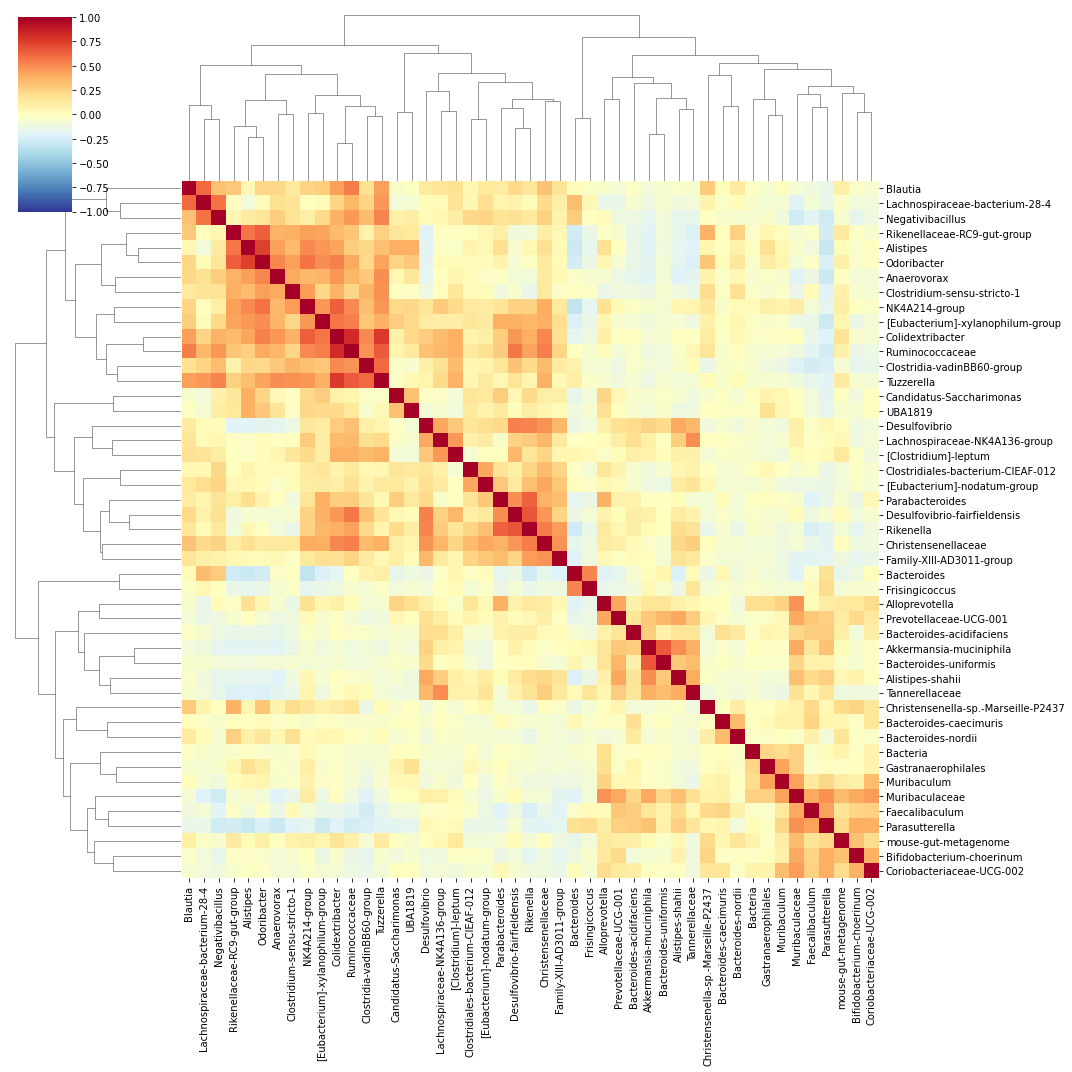

In [162]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet==diet]

# read bacterial absolute abundance
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# select the species included in glv model
df_sig_ir = pd.read_csv('../../figure4_individualized_response/inulin/bacterial_species_w_sig_individualized_response.csv', index_col=0)
df_bac = df_bac[list(df_sig_ir.index)]

# plot clustermap
df_corr = df_bac.corr(method='pearson').loc[list(df_bac.columns), list(df_bac.columns)]
fig = sns.clustermap(df_corr,
                   cmap='RdYlBu_r',
                   vmin=-1,
                   vmax=1,
                   figsize=(15,15)
                  )
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('correlation_inulin_responder_vs_species_w_sig_ir.svg', format='svg')

# Identify baseline species that explains overall responses of responders (area under curve)

## baseline absolute abundance vs. absolute abundance of species w/ individualized response

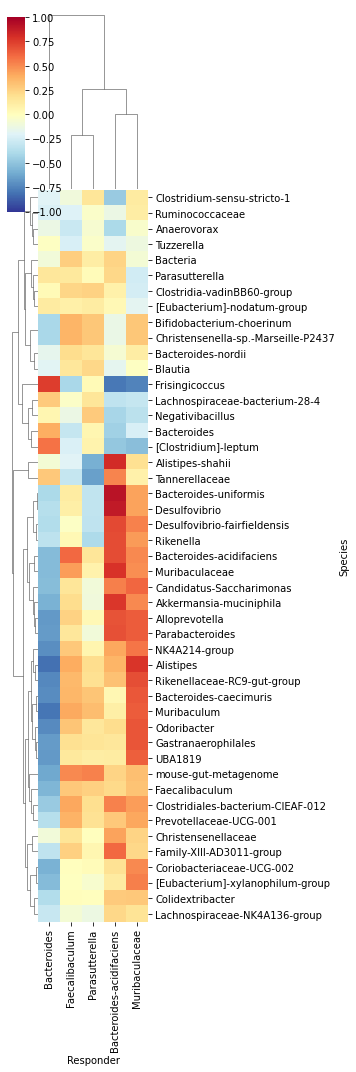

In [7]:
# read bacterial absolute abundance
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_bac = df_bac.loc[df_meta.index]
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True)

# use species that show significant individualized responses
inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
df_sig_ir = pd.read_csv('../../figure4_individualized_response/inulin/bacterial_species_w_sig_individualized_response.csv', index_col=0)
all_species = list(df_sig_ir.index)

lines = []
for sp in all_species:
    for responder in inulin_responders:
        baseline = []
        normalized_auc = []
        for mice in set(df_meta.MiceID):
            df_tmp = df_meta_bac[df_meta_bac.MiceID==mice].sort_values(by='Day')
            vendor = list(set(df_tmp['Vendor']))[0]
            baseline.append(list(df_tmp[sp])[0])
            x = list(df_tmp.Day)
            y = list(df_tmp[responder])
            normalized_auc.append(simps(y,x)/np.max(x)) # area under the curve divided by duration        
        scorr, sP = spearmanr(baseline,normalized_auc)
        rcorr, rP = pearsonr(baseline,normalized_auc)
        lines.append([sp, responder, scorr, sP, rcorr, rP])

# save spearman correlation file
df_baseline_responder_assoc = pd.DataFrame(lines, columns=['Species','Responder','PearsonCoef','PearsonP','SpearmanCoef','SpearmanP'])
df_baseline_responder_assoc = df_baseline_responder_assoc.dropna()
df_baseline_responder_assoc['PearsonPCorrected'] = multipletests(df_baseline_responder_assoc['PearsonP'],method='fdr_bh')[1]
df_baseline_responder_assoc['SpearmanCorrected'] = multipletests(df_baseline_responder_assoc['SpearmanP'],method='fdr_bh')[1]
df_baseline_responder_assoc.to_csv('baseline_species_vs_inulin_responder_correlation_absolute_abundance.csv')

# plot clustermap
df_corr = pd.pivot_table(df_baseline_responder_assoc[['Species','Responder','PearsonCoef']],
                         index='Species',
                         columns='Responder',
                         values='PearsonCoef').reset_index().set_index('Species')
fig = sns.clustermap(df_corr,
                     cmap='RdYlBu_r',
                     vmin=-1,
                     vmax=1,
                     figsize=(5,15)
                     )
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('baseline_responder_correlation_inulin_absolute_abundance.svg', format='svg')

## baseline relative abundance vs. absolute abundance of species w/ individualized response

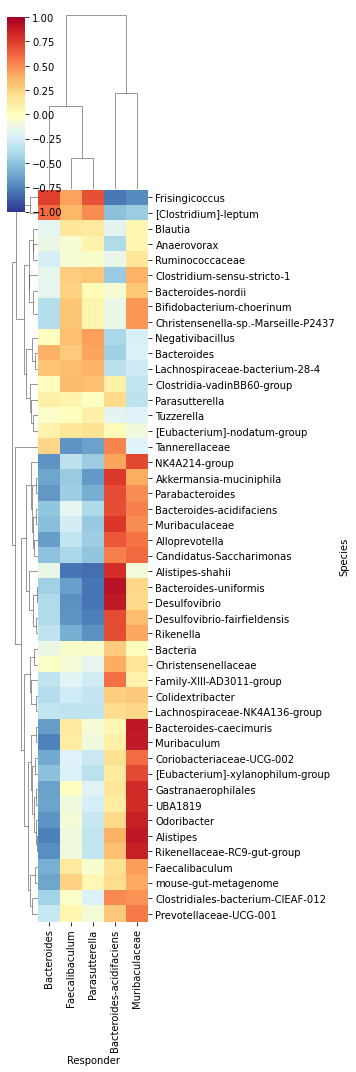

In [9]:
# read bacterial relative abundance
df_bac = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)

# read bacterial absolute abundance
df_bac_baseline = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_bac = df_bac.loc[df_meta.index]
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True)

# use species that show significant individualized responses
inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
df_sig_ir = pd.read_csv('../../figure4_individualized_response/inulin/bacterial_species_w_sig_individualized_response.csv', index_col=0)
all_species = list(df_sig_ir.index)

lines = []
for sp in all_species:
    for responder in inulin_responders:
        baseline = []
        normalized_auc = []
        for mice in set(df_meta.MiceID):
            df_tmp = df_meta_bac[df_meta_bac.MiceID==mice].sort_values(by='Day')
            sampleid = list(df_tmp.index)[0]
            vendor = list(set(df_tmp['Vendor']))[0]
            baseline.append(df_bac_baseline.loc[sampleid,sp])
            x = list(df_tmp.Day)
            y = list(df_tmp[responder])
            normalized_auc.append(simps(y,x)/np.max(x)) # area under the curve divided by duration        
        scorr, sP = spearmanr(baseline,normalized_auc)
        rcorr, rP = pearsonr(baseline,normalized_auc)
        lines.append([sp, responder, scorr, sP, rcorr, rP])

# save spearman correlation file
df_baseline_responder_assoc = pd.DataFrame(lines, columns=['Species','Responder','PearsonCoef','PearsonP','SpearmanCoef','SpearmanP'])
df_baseline_responder_assoc = df_baseline_responder_assoc.dropna()
df_baseline_responder_assoc['PearsonPCorrected'] = multipletests(df_baseline_responder_assoc['PearsonP'],method='fdr_bh')[1]
df_baseline_responder_assoc['SpearmanCorrected'] = multipletests(df_baseline_responder_assoc['SpearmanP'],method='fdr_bh')[1]
df_baseline_responder_assoc.to_csv('baseline_species_vs_inulin_responder_correlation_absolute_abundance.csv')

# plot clustermap
df_corr = pd.pivot_table(df_baseline_responder_assoc[['Species','Responder','PearsonCoef']],
                         index='Species',
                         columns='Responder',
                         values='PearsonCoef').reset_index().set_index('Species')
fig = sns.clustermap(df_corr,
                     cmap='RdYlBu_r',
                     vmin=-1,
                     vmax=1,
                     figsize=(5,15)
                     )
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('baseline_responder_correlation_inulin_relative_abundance.svg', format='svg')